# Part 2

This notebook will answer all the questions in part 2

In [1]:
from datasets import load_dataset
from utils.rnn_model import *
from utils.rnn_utils import *
from utils.utils import *
from dotenv import load_dotenv
import os

load_dotenv()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Dataset Preparation 

First, we define all relevant hyperparameters, then we load the dataset.

After which, we will load the word embeddings and process the data accordingly

In [2]:
BATCH_SIZE = 32

In [3]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

### Word Embedding

We load the pre-trained Google News 300 dimension Word2Vec model and obtain a word index to be used later in data processing

In [4]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

In [5]:
word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [6]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

In [7]:
word2vec_model.vector_size

350

### Dataloaders

Once we have the dataset and the word index both loaded, we can proceed with building the dataloaders for batch training. We first prepare the data by tokenizing and padding the data so that they are all of the same length

In [8]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

Once the data is processed, we create dataloaders for the data for batch training

In [9]:
trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

# Models

Once again, we define all relevant hyperparameters

In [10]:
LR = 0.0001
MODEL_TYPE = "rnn"

## 1. Last State Sentence Representation

We initialise the model for the default RNN without any extra processing to derive the final sentence representation

In [11]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
    pooling_method="last_state"
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [12]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode='last_state'
)

Epoch   1/100, Loss: 0.6953, Accuracy: 0.5225
Model saved.
Epoch   2/100, Loss: 0.6902, Accuracy: 0.5131
Epoch   3/100, Loss: 0.6816, Accuracy: 0.5319
Model saved.
Epoch   4/100, Loss: 0.6695, Accuracy: 0.5779
Model saved.
Epoch   5/100, Loss: 0.6525, Accuracy: 0.5807
Model saved.
Epoch   6/100, Loss: 0.6354, Accuracy: 0.5647
Epoch   7/100, Loss: 0.6136, Accuracy: 0.5535
Epoch   8/100, Loss: 0.5974, Accuracy: 0.5610
Epoch   9/100, Loss: 0.5784, Accuracy: 0.5488
Epoch  10/100, Loss: 0.5618, Accuracy: 0.5563
Epoch  11/100, Loss: 0.5512, Accuracy: 0.5525
Epoch  12/100, Loss: 0.5360, Accuracy: 0.5441
Epoch  13/100, Loss: 0.5234, Accuracy: 0.5610
Epoch  14/100, Loss: 0.5142, Accuracy: 0.5516
Epoch  15/100, Loss: 0.5019, Accuracy: 0.5478
Early stopping triggered after 15 epochs.
Training ended, loading best model...
Model loaded.


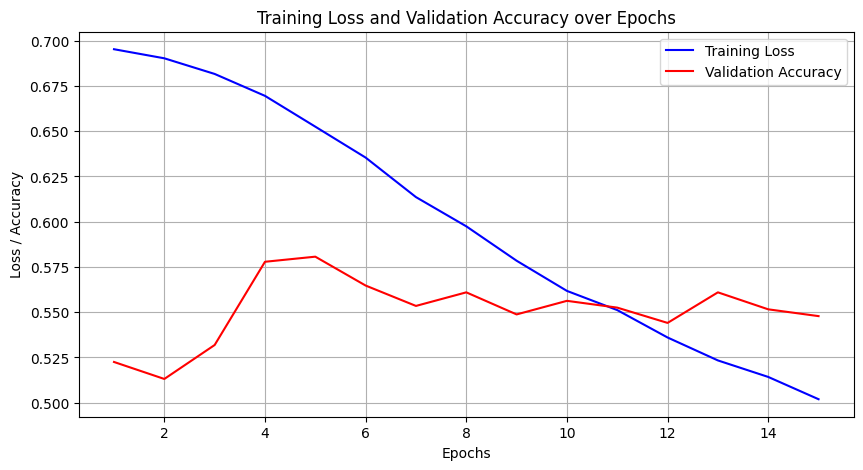

In [13]:
plot_loss_accuracy(losses, accuracies)

Test the model on the test set to obtain the accuracy

In [14]:
last_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.5844


## 2. Mean Pooling RNN

This RNN will use the average of all hidden vectors as the sentence representation. This captures information across the whole sentence by averaging the all the words' contributions

In [15]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
    pooling_method="mean_pool"
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [16]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_pool"
)

Epoch   1/100, Loss: 0.6929, Accuracy: 0.5422
Model saved.
Epoch   2/100, Loss: 0.6829, Accuracy: 0.5507
Model saved.
Epoch   3/100, Loss: 0.6708, Accuracy: 0.5685
Model saved.
Epoch   4/100, Loss: 0.6619, Accuracy: 0.5732
Model saved.
Epoch   5/100, Loss: 0.6514, Accuracy: 0.5826
Model saved.
Epoch   6/100, Loss: 0.6501, Accuracy: 0.5929
Model saved.
Epoch   7/100, Loss: 0.6465, Accuracy: 0.5844
Epoch   8/100, Loss: 0.6424, Accuracy: 0.5863
Epoch   9/100, Loss: 0.6384, Accuracy: 0.5844
Epoch  10/100, Loss: 0.6371, Accuracy: 0.5779
Epoch  11/100, Loss: 0.6381, Accuracy: 0.5826
Epoch  12/100, Loss: 0.6331, Accuracy: 0.5901
Epoch  13/100, Loss: 0.6320, Accuracy: 0.5872
Epoch  14/100, Loss: 0.6310, Accuracy: 0.5854
Epoch  15/100, Loss: 0.6278, Accuracy: 0.5572
Epoch  16/100, Loss: 0.6263, Accuracy: 0.5891
Early stopping triggered after 16 epochs.
Training ended, loading best model...
Model loaded.


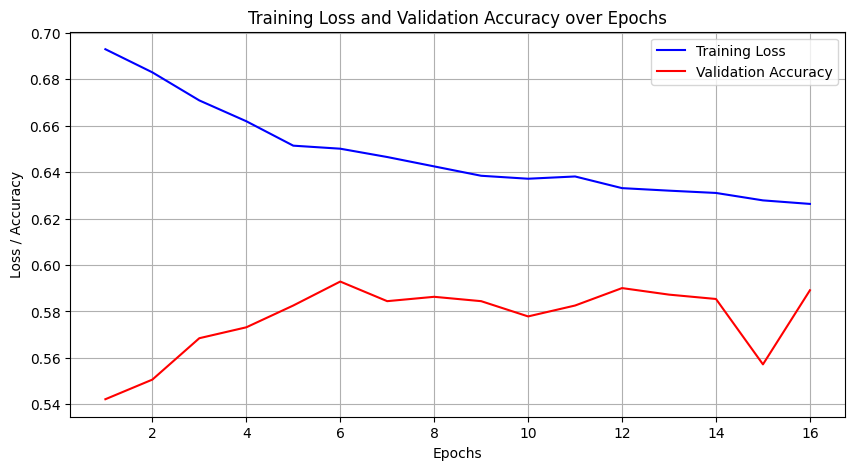

In [17]:
plot_loss_accuracy(losses, accuracies)

Test the model on the test set to obtain the accuracy

In [18]:
mean_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6201


## 3. Max Pool RNN

This RNN will compute the max of all hidden vectors along each dimension. This will effectively use the most significant word as the representation of the sentence

In [19]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
    pooling_method="max_pool"
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [20]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pool"
)

Epoch   1/100, Loss: 0.6932, Accuracy: 0.5722
Model saved.
Epoch   2/100, Loss: 0.6807, Accuracy: 0.5666
Epoch   3/100, Loss: 0.6679, Accuracy: 0.5919
Model saved.
Epoch   4/100, Loss: 0.6559, Accuracy: 0.5994
Model saved.
Epoch   5/100, Loss: 0.6473, Accuracy: 0.6051
Model saved.
Epoch   6/100, Loss: 0.6413, Accuracy: 0.6060
Model saved.
Epoch   7/100, Loss: 0.6346, Accuracy: 0.6041
Epoch   8/100, Loss: 0.6301, Accuracy: 0.5901
Epoch   9/100, Loss: 0.6230, Accuracy: 0.6098
Model saved.
Epoch  10/100, Loss: 0.6172, Accuracy: 0.6116
Model saved.
Epoch  11/100, Loss: 0.6133, Accuracy: 0.6069
Epoch  12/100, Loss: 0.6089, Accuracy: 0.6041
Epoch  13/100, Loss: 0.6000, Accuracy: 0.6229
Model saved.
Epoch  14/100, Loss: 0.5957, Accuracy: 0.6144
Epoch  15/100, Loss: 0.5895, Accuracy: 0.6173
Epoch  16/100, Loss: 0.5811, Accuracy: 0.6135
Epoch  17/100, Loss: 0.5768, Accuracy: 0.6182
Epoch  18/100, Loss: 0.5680, Accuracy: 0.6266
Model saved.
Epoch  19/100, Loss: 0.5614, Accuracy: 0.6304
Model sav

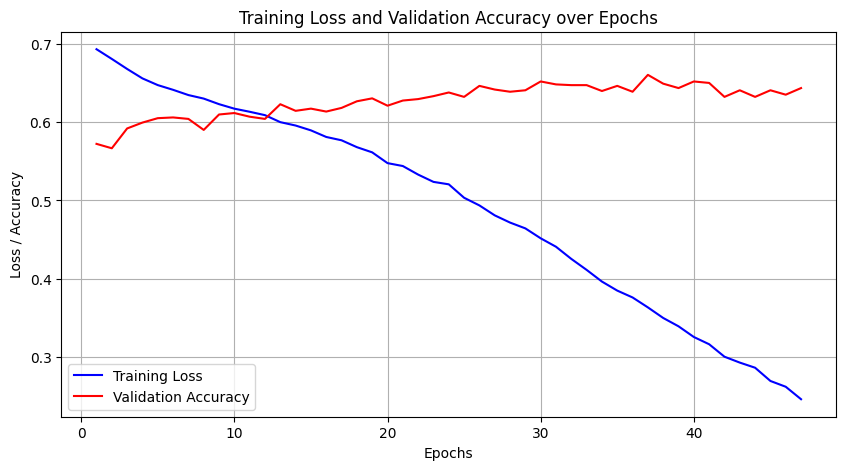

In [21]:
plot_loss_accuracy(losses, accuracies)

Test the model on the test set to obtain the accuracy

In [22]:
max_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6670


## 4. Mean and Max Pooled RNN

This RNN will compute the average of both the Mean pooled and Max pooled values. This should be able to smooth out the pros and cons of both Mean Pooling and Max Pooling

In [23]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
    pooling_method="mean_max"
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [24]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6924, Accuracy: 0.5525
Model saved.
Epoch   2/100, Loss: 0.6836, Accuracy: 0.5704
Model saved.
Epoch   3/100, Loss: 0.6690, Accuracy: 0.5882
Model saved.
Epoch   4/100, Loss: 0.6589, Accuracy: 0.5938
Model saved.
Epoch   5/100, Loss: 0.6525, Accuracy: 0.5816
Epoch   6/100, Loss: 0.6467, Accuracy: 0.5882
Epoch   7/100, Loss: 0.6419, Accuracy: 0.5966
Model saved.
Epoch   8/100, Loss: 0.6377, Accuracy: 0.5713
Epoch   9/100, Loss: 0.6350, Accuracy: 0.5919
Epoch  10/100, Loss: 0.6364, Accuracy: 0.6013
Model saved.
Epoch  11/100, Loss: 0.6280, Accuracy: 0.5976
Epoch  12/100, Loss: 0.6261, Accuracy: 0.6069
Model saved.
Epoch  13/100, Loss: 0.6250, Accuracy: 0.6069
Epoch  14/100, Loss: 0.6199, Accuracy: 0.5929
Epoch  15/100, Loss: 0.6188, Accuracy: 0.5947
Epoch  16/100, Loss: 0.6145, Accuracy: 0.6069
Epoch  17/100, Loss: 0.6130, Accuracy: 0.6013
Epoch  18/100, Loss: 0.6095, Accuracy: 0.6041
Epoch  19/100, Loss: 0.6051, Accuracy: 0.6163
Model saved.
Epoch  20/100, Loss: 0

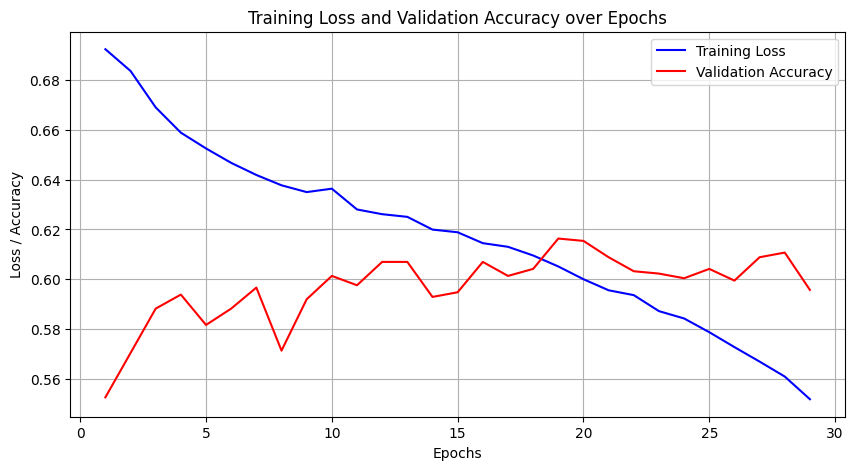

In [25]:
plot_loss_accuracy(losses, accuracies)

Test the model on the test set to obtain the accuracy

In [26]:
meanmax_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6370


## 5. Attention RNN

This RNN applies an attention mask on the output vectors

In [27]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
    pooling_method="attention"
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [28]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="attention"
)

Epoch   1/100, Loss: 0.6913, Accuracy: 0.5281
Model saved.
Epoch   2/100, Loss: 0.6824, Accuracy: 0.5647
Model saved.
Epoch   3/100, Loss: 0.6712, Accuracy: 0.5722
Model saved.
Epoch   4/100, Loss: 0.6624, Accuracy: 0.5882
Model saved.
Epoch   5/100, Loss: 0.6552, Accuracy: 0.5957
Model saved.
Epoch   6/100, Loss: 0.6499, Accuracy: 0.5872
Epoch   7/100, Loss: 0.6452, Accuracy: 0.5985
Model saved.
Epoch   8/100, Loss: 0.6416, Accuracy: 0.5938
Epoch   9/100, Loss: 0.6388, Accuracy: 0.5929
Epoch  10/100, Loss: 0.6368, Accuracy: 0.5854
Epoch  11/100, Loss: 0.6340, Accuracy: 0.5779
Epoch  12/100, Loss: 0.6348, Accuracy: 0.5807
Epoch  13/100, Loss: 0.6301, Accuracy: 0.5732
Epoch  14/100, Loss: 0.6273, Accuracy: 0.6032
Model saved.
Epoch  15/100, Loss: 0.6233, Accuracy: 0.5807
Epoch  16/100, Loss: 0.6203, Accuracy: 0.5835
Epoch  17/100, Loss: 0.6186, Accuracy: 0.5872
Epoch  18/100, Loss: 0.6160, Accuracy: 0.5872
Epoch  19/100, Loss: 0.6126, Accuracy: 0.5929
Epoch  20/100, Loss: 0.6079, Accura

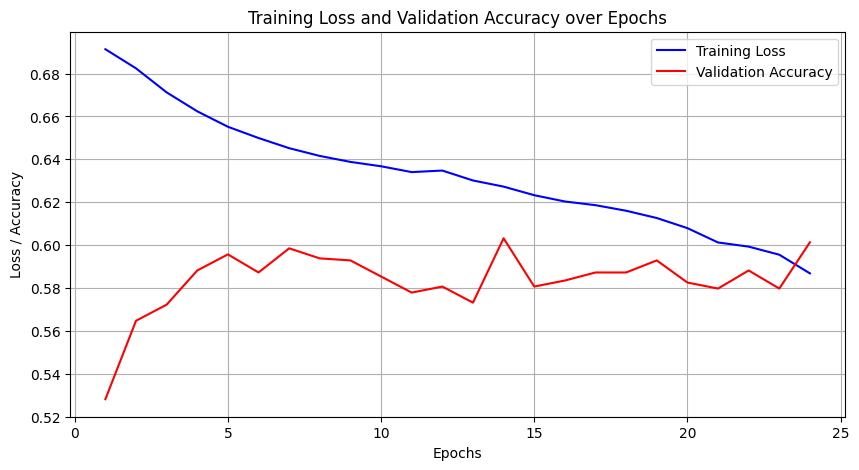

In [29]:
plot_loss_accuracy(losses, accuracies)

Test the model on the test set to obtain the accuracy

In [30]:
attn_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6248


# Results

In [31]:
print(f"Last State Test Accuracy:       {last_tst_accuracy:.4f}")
print(f"Mean Pool Test Accuracy:        {mean_tst_accuracy:.4f}")
print(f"Max Pool Test Accuracy:         {max_tst_accuracy:.4f}")
print(f"Mean Max Pool Test Accuracy:    {meanmax_tst_accuracy:.4f}")
print(f"Attention Test Accuracy:        {attn_tst_accuracy:.4f}")

Last State Test Accuracy:       0.5844
Mean Pool Test Accuracy:        0.6201
Max Pool Test Accuracy:         0.6670
Mean Max Pool Test Accuracy:    0.6370
Attention Test Accuracy:        0.6248


Based on the test accuracies, the RNN that uses the Max Pooling has the highest test accuracy.

This is likely because the sentiment is largely dependent on specific words that determine the entire sentence, for eg "horrible", or "amazing". Other words may have an impact on the sentiment, but these impacts are unlikely to be as large as these specific words. Hence, taking the Max Pooled sentence representation makes sense to have a higher accuracy.